# 02 Uudiste kogumine Uute Uudiste veebilehelt

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import csv
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm
import pandas as pd
from wordcloud import WordCloud
from estnltk import Text

Uued Uudised veebilehtelt  https://uueduudised.ee/arhiiv/ koguti veebiämblikuga uudisartiklite lingid. Kogutud lingid on failis:  uued_uudised_scraper/uued_uudised_scraper/spiders/uueduudised_rubriigid_arhiiv.csv

Linkide kogumiseks kasutatud valikukriteeriumid:

Rubriigid:

•	Arvamus

•	Eesti

•	Maailm

•	Majandus

In [21]:
# Uued Uudised veebilehelt veebiämblikuga kogutud lingid loetakse listi

# list Uued Uudised linkide jaoks
urls_uueduudised_toor = []

with open('uued_uudised_scraper/uued_uudised_scraper/spiders/uueduudised_rubriigid_arhiiv.csv', 'r', encoding = 'utf-8') as f:
    reader = csv.reader(f)
    for line in reader:
        if line != []:
            urls_uueduudised_toor.append(line[0])
# linkide failis esimene rida ei ole uudise link
print(len(urls_uueduudised_toor)-1)

14417


In [22]:
# võimalike topeltlinkide eemaldamine
urls_uueduudised = list(dict.fromkeys(urls_uueduudised_toor))
print("Uued Uudised veebilehtedelt kogutud linkide arv: ", len(urls_uueduudised)-1)

Uued Uudised veebilehtedelt kogutud linkide arv:  14245


Uued Uudised veebilehtedelt kogutud linkidelt saadakse BeautifulSoup abil järgmine info:

1) väljaande nimi

2) artikli pealkiri

3) artikli tekst

4) artikli publitseerimise kuupäev

Teiste väljaannetega võrreldavuse huvides vähendatakse uuritavate artiklite hulka, vaadeldakse 6000 artiklit.

In [4]:
headers = requests.utils.default_headers()
headers.update(
  { 'User-Agent': 'my crawler (anneliis@ut.ee) / on studying purpose', }
)

pealkirjad = []
tekstid = []
väljaanded = []
ajad =[]
reklaamiteade = 'Järgneb Google reklaam. Uute uudiste toimetus ei vastuta Google algoritmide poolt personaalselt teile suunatud reklaamide sisu eest. Soovitame usaldada ainult tuntud ja usaldusväärseid kaubamärke.'
for url in tqdm(urls_uueduudised[1:6001]):
    try:
        response = requests.get(url, headers=headers)
        soup = BeautifulSoup(response.text, 'html.parser')

        pealkiri = soup.find("meta", {"property" : "og:title"})['content']
        pealkiri = pealkiri.replace('\xa0','')
        väljaanne = soup.find("meta", {"property" : "og:site_name"})['content']
        aeg = soup.find("meta", {"itemprop" : "datePublished"})['content']

        artikkel = soup.findAll("div", {"itemprop" : "articleBody"})
        
        yhendatud_tekst = ''
        for art in artikkel:
            loik = art.find_all("p")
            for l in loik:
                if reklaamiteade not in l.text:
                    text = l.text.replace('\n','')
                    text = text.replace('\xa0','')
                    text = text + ' '
                    yhendatud_tekst += text
        tekstid.append(yhendatud_tekst)
    except Exception as e:
        print("Exception is :", e, url)
       
    pealkirjad.append(pealkiri)
    väljaanded.append(väljaanne)
    ajad.append(aeg)

100%|██████████████████████████████████████████████████████████████████████████████| 6000/6000 [53:19<00:00,  1.88it/s]


Kogutud info uudisartiklite kohta koondatakse sõnastikuks.

In [5]:
artiklid_6000 = {'title': pealkirjad, 'text': tekstid,'subject': väljaanded, 'date': ajad, 'link': urls_uueduudised[1:6001]}

Kogutud sõnastik esitatakse tabeli kujul. Tabelis on viis veergu:

1) artikli pealkiri

2) artikli tekst

3) artikli väljaandja

4) artikli publitseerimise kuupäev

5) artikli link

In [6]:
data_uueduudised_rubriigid = pd.DataFrame(artiklid_6000, columns = ['title', 'text','subject', 'date', 'link'])

In [8]:
data_uueduudised_rubriigid.shape

(6000, 5)

Järgnevalt filtreeritakse välja tühjade väljadega uudisartiklid.

In [9]:
data_uueduudised_rubriigid.dropna(inplace=True)

In [10]:
data_uueduudised_rubriigid.shape

(6000, 5)

In [12]:
data_uueduudised_rubriigid = data_uueduudised_rubriigid[(data_uueduudised_rubriigid.text != '') & (data_uueduudised_rubriigid.title != '') & (data_uueduudised_rubriigid.subject != '') & (data_uueduudised_rubriigid.date != '') ]

In [13]:
data_uueduudised_rubriigid.shape

(6000, 5)

In [14]:
data_uueduudised_rubriigid.to_csv('data_uueduudised_UUS.csv',index=False)

subject
Uued Uudised    6000
Name: text, dtype: int64


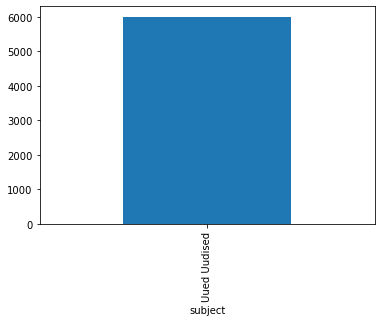

In [15]:
# Artiklite jaotus väljaandjate kaupa
print(data_uueduudised_rubriigid.groupby(['subject'])['text'].count())
data_uueduudised_rubriigid.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

# Sõnapilvede loomine

In [16]:
#https://et.wikipedia.org/wiki/Sides%C3%B5na
#https://www.taskutark.ee/m/asesonad/
#sidesõnad
stopsõnad = ['ja', 'ning', 'ega', 'ehk', 'või', 'aga', 'kuid', 'ent', 'vaid', 'et', 'kui', 'kuna', 'sest', 'kuni', 'kuigi', 
             'ehkki', 'nagu', 'saati', 'elik', 'justkui', 'otsekui', 'seni']
#sidesõnad ja asesõnad
stopsõnad_uus = ['ja', 'ning', 'ega', 'ehk', 'või', 'aga', 'kuid', 'ent', 'vaid', 'et', 'kui', 'kuna', 'sest', 'kuni', 'kuigi', 
             'ehkki', 'nagu', 'saati', 'elik', 'justkui', 'otsekui', 'seni', 'siis', 'ka', 'nii', 'kas',
             'mina', 'ma', 'meie', 'me', 'sina', 'sa', 'teie', 'te', 'tema', 'ta', 'nemad', 'nad',
             'enese', 'enda', 'iseenese', 'iseenda', 'oma', 'üksteise', 'teineteise',
             'see', 'too', 'sama', 'seesama', 'toosama', 'teine', 'muu',
             'niisugune', 'samasugune', 'niisamasugune', 'selline', 'seesugune', 'säärane','säherdune', 
             'taoline', 'selletaoline', 'kes', 'mis', 'kumb', 'missugune', 'milline', 'misuke', 'mitu', 'mitmes', 'mitmendik',
             'ise', 'oma', 'iga', 'igaüks', 'igamees', 'kõik', 'mõlemad', 'kumbki', 'emb-kumb', 'kogu', 'terve',
             'keegi', 'miski', 'mingi', 'mingisugune', 'miskisugune', 'ükski', 'mitu', 'mitmes', 'mitu-setu', 'mitmes-setmes',
             'mõni', 'mõningane', 'paljud', 'üks', 'teine', 'oma', 'enese', 'enda', 'omaenese', 'omaenda', 'iseoma', 
             'iseenese', 'iseenda', 'emb', 'mõlema', 'palju']

# Nimi- ja omadussõnade kasutamine

EstNLTK vahenditega vaadeldakse Uutes Uudistes esinevate sõnade lemmasid ja sõnade liike. Edaspidiseks vaatluseks eraldatakse nimisõnad (sõnaliik S) ja  omadussõnad (sõnaliigid A - algvõrre, C - keskvõrre, U - ülivõrre).

In [23]:
# Uutes uudistes nimisõnade ja omadussõnade kasutamine

nimi_omadus_sonad = []
for i in tqdm(range (0, len(data_uueduudised_rubriigid))):
    rida = data_uueduudised_rubriigid.iloc[i]
    tekst = Text(rida[1]).tag_layer().morph_analysis['lemma','partofspeech']
    for sona in tekst:
        if sona[0][1] == 'S' or sona[0][1] == 'A' or sona[0][1] == 'C' or sona[0][1] == 'U':
            nimi_omadus_sonad.append(sona[0][0])

nimi_omadus_words = ' '.join(map(str, nimi_omadus_sonad))

100%|██████████████████████████████████████████████████████████████████████████████| 6000/6000 [21:23<00:00,  4.68it/s]


Nimisõnu ja omadussõnu sõnapilves:  803166


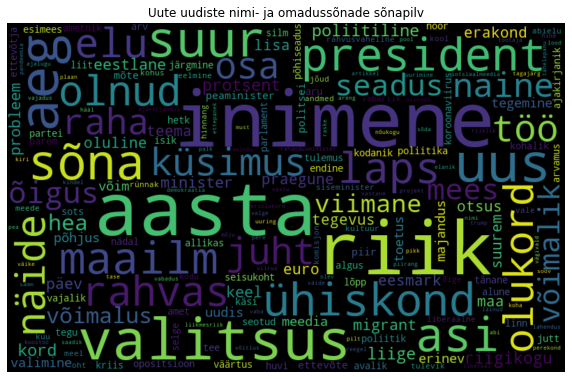

In [24]:
wordcloud_nimi_omadus = WordCloud(stopwords = stopsõnad_uus, width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(nimi_omadus_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud_nimi_omadus, interpolation='bilinear')
plt.title("Uute uudiste nimi- ja omadussõnade sõnapilv")
plt.savefig('Uute_uudiste_nimi_omadus_sõnapilv_UUS.png')
plt.axis("off")
print("Nimisõnu ja omadussõnu sõnapilves: ", len(nimi_omadus_sonad))

## Nimi- ja omadussõnade esinemissagedus ning osakaal

In [25]:
df_1 =pd.DataFrame(nimi_omadus_sonad, columns=['sõna'])
sagedused_1 = df_1.groupby(['sõna']).size().reset_index(name='esinemissagedus').sort_values(by='esinemissagedus', ascending=False)[:10]
sagedused_1['osakaal %']= (sagedused_1['esinemissagedus']/len(nimi_omadus_sonad)*100)

In [26]:
print("Uute Uudiste nimisõnade ja omadussõnade TOP 10")
sagedused_1

Uute Uudiste nimisõnade ja omadussõnade TOP 10


,sõna,esinemissagedus,osakaal %
11985,inimene,9287,1.156299
1072,aasta,8683,1.081097
40296,riik,8228,1.024446
52470,valitsus,4596,0.572235
1436,aeg,4322,0.538120
51543,uus,4143,0.515834
44583,suur,3450,0.429550
45145,sõna,3352,0.417348
3494,asi,3081,0.383607
36112,president,2905,0.361694


# Verbide kasutamine

In [19]:
verb_sonad = []
for i in tqdm(range (0, len(data_uueduudised_rubriigid))):
    rida = data_uueduudised_rubriigid.iloc[i]
    tekst = Text(rida[1]).tag_layer().morph_analysis['lemma','partofspeech']
    for sona in tekst:
        if sona[0][1] == 'V': #or sona[0][1] == 'A' or sona[0][1] == 'C' or sona[0][1] == 'U' or sona[0][1] == 'D':
            verb_sonad.append(sona[0][0])

verb_words = ' '.join(map(str, verb_sonad))

100%|██████████████████████████████████████████████████████████████████████████████| 6000/6000 [20:54<00:00,  4.78it/s]


Verbe sõnapilves:  416052


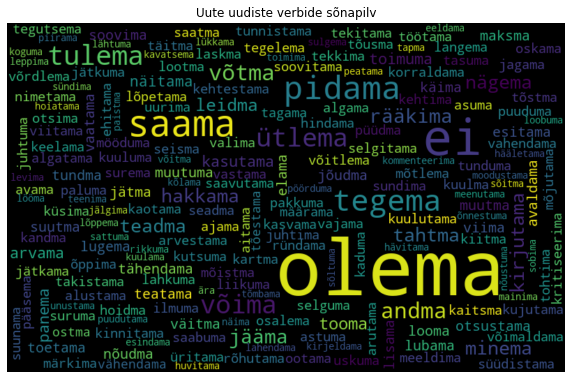

In [20]:
wordcloud_verb = WordCloud(stopwords = stopsõnad_uus, width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(verb_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud_verb, interpolation='bilinear')
plt.title("Uute uudiste verbide sõnapilv")
plt.savefig('Uute_uudiste_sõnapilv_verb_sonad_UUS.png')
plt.axis("off")
print("Verbe sõnapilves: ", len(verb_sonad))

## Verbide esinemissagedus ja osakaal

In [27]:
df_2 =pd.DataFrame(verb_sonad, columns=['sõna'])
sagedused_2 = df_2.groupby(['sõna']).size().reset_index(name='esinemissagedus').sort_values(by='esinemissagedus', ascending=False)[:10]
sagedused_2['osakaal %']= (sagedused_2['esinemissagedus']/len(verb_sonad)*100)

In [28]:
print("Uute Uudiste verbide TOP 10")
sagedused_2

Uute Uudiste verbide TOP 10


,sõna,esinemissagedus,osakaal %
1835,olema,97165,23.354052
264,ei,27459,6.599896
2380,saama,12442,2.990492
1970,pidama,9342,2.245392
2774,tegema,8004,1.923798
2908,tulema,6689,1.607732
3408,ütlema,6074,1.459914
3288,võima,6028,1.448857
3310,võtma,4441,1.067415
88,andma,4287,1.030400
